### Transport algorithm to calculate upwelled water (and tracer) 

Define shelf boundary and calculate volume of water transported onto the shelf through cells with $C_i \ge C_s$

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('white')

In [4]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 4D arrays 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    
    rho = RhoRef*np.ones(np.shape(T)) - alpha*(T) + beta*(S)
    return rho

def call_rho(tslice,state,zslice,yslice,xslice):
    T = state.Temp.isel(T=tslice,Z=zslice,X=xslice,Y=yslice)
    S = state.S.isel(T=tslice,Z=zslice,X=xslice,Y=yslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

### Input 

Select experiment, runs, indices, tracer

In [5]:
# Select experiment and run
exp = 'UPW_10TR_BF3_AST'
run = '04_Ast03_No_Cny_Argo'

# Define subdomain alongshelf  (5W)
W1 = 120               # downstream x-ind for canyon mouth: 140 Barkley,120 Astoria 
W2 = 240               # upstream x-ind for canyon mouth: 220 Barkley, 240 Astoria
num_cells = 100         # num of cells to extend domain upstream and downstream of the canyon mouth: 79 Bar, 100 Ast
W_ini = W1 - num_cells # Start of CS section, alongshore index
W_end = W2 + num_cells # End of CS section, alongshore index

# Shelfbreak indices
y_ind = 129 # sb index 129 for Barkley and Astoria
z_ind = 29 # sb index: 39 Barkley, 29 Astoria

# CS and LID slices
x_slice = slice(W_ini,W_end) # subdomain slice alongshelf
x_slice_vert = slice(W_ini,W_end)  # x-slice for LID
y_slice_vert = slice(y_ind,y_ind+100) # y-slice for LID

# Virtual station x and y indices (to get initial profile)
x_st = 180
y_st = 50

RhoRef = 999.79998779 

In [6]:
# get bathy variables and xarray datasets
Grid = '/data/kramosmu/results/TracerExperiments/%s/%s/gridGlob.nc' %(exp,run) 
with Dataset(Grid, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    Y = nbl.variables['Y'][:]
    X = nbl.variables['X'][:]
    hFac = nbl.variables['HFacC'][:]
    Depth = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFac, 0)
    maskC = np.ma.getmask(hfac)
    rA = nbl.variables['rA'][:]
    dxg = nbl.variables['dxG'][:]
    drf = nbl.variables['drF'][:]
    Zf = nbl.variables['RF'][:]

State = '/data/kramosmu/results/TracerExperiments/%s/%s/stateGlob.nc' %(exp, run) 
st = xr.open_dataset(State)

Ptracer = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(exp, run) 
ptr = xr.open_dataset(Ptracer)

**Algorithm**

In [7]:
# Get threshold concentration Cs
Cs = ptr.Tr01[0,z_ind,y_st,x_st]
t_slice = slice(0,19)

# Mask tracer 1 at Cs and LID using Cs criterion
Tr_adv = np.ma.masked_less(ptr.Tr01[t_slice,:z_ind+1,y_ind,x_slice], Cs)
Tr_adv_v = np.ma.masked_less(ptr.Tr01[t_slice,z_ind,y_slice_vert,x_slice_vert], Cs)

# Get tracer mask
mask_cs = np.ma.getmask(Tr_adv)
mask_vert = np.ma.getmask(Tr_adv_v)

# Get V and unstagger
V = st.V.isel(T = t_slice, Z=slice(0,z_ind+1))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_CS = V[...,y_ind,x_slice]

# Apply tracer mask to unstaggered V
V_upw = np.ma.masked_array(V_CS, mask = mask_cs)

# Calculate water transport
drf_exp = np.expand_dims(np.expand_dims(drf[:z_ind+1],1),0)
drf_exp = drf_exp + np.zeros(mask_cs.shape)

dxg_exp = np.expand_dims(np.expand_dims(dxg[y_ind,x_slice],0),0)
dxg_exp = dxg_exp + np.zeros(mask_cs.shape)

hfac_exp = mpt.maskExpand(hfac[:z_ind+1,y_ind,x_slice],mask_cs)
wat_CS = drf_exp*dxg_exp*hfac_exp*V_upw

# Calculate tracer transport
density = call_rho(t_slice,st,slice(0,z_ind+1),y_ind,x_slice)
Tr01_CS = wat_CS * np.ma.masked_array(ptr.Tr01[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr02_CS = wat_CS * np.ma.masked_array(ptr.Tr02[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr04_CS = wat_CS * np.ma.masked_array(ptr.Tr04[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr05_CS = wat_CS * np.ma.masked_array(ptr.Tr05[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr06_CS = wat_CS * np.ma.masked_array(ptr.Tr06[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr07_CS = wat_CS * np.ma.masked_array(ptr.Tr07[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr08_CS = wat_CS * np.ma.masked_array(ptr.Tr08[t_slice,:z_ind+1,y_ind,x_slice], mask = mask_cs)
Tr03 = density * ptr.Tr03[t_slice,:z_ind+1,y_ind,x_slice]/1000
Tr03_CS = wat_CS * np.ma.masked_array(Tr03, mask = mask_cs)
Tr09 = density * ptr.Tr09[t_slice,:z_ind+1,y_ind,x_slice]/1000
Tr09_CS = wat_CS * np.ma.masked_array(Tr09, mask = mask_cs)
Tr10 = density * ptr.Tr10[t_slice,:z_ind+1,y_ind,x_slice]/1000
Tr10_CS = wat_CS * np.ma.masked_array(Tr10, mask = mask_cs)

# Select W at LID
W_LID = st.W[t_slice,z_ind,y_slice_vert,x_slice_vert]

# Apply tracer mask to W and calculate vertical transport of water
rA_exp = np.expand_dims(rA[y_slice_vert,x_slice_vert], 0)
rA_exp = rA_exp + np.zeros(np.shape(W_LID))
wat_LID = np.ma.masked_array(W_LID*rA_exp, mask=mask_vert)

# Caluclate vertical transport of tracer (units uM or nM)
density = call_rho(t_slice,st,z_ind,y_slice_vert,x_slice_vert)
Tr01_LID = wat_LID * np.ma.masked_array(ptr.Tr01[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr02_LID = wat_LID * np.ma.masked_array(ptr.Tr02[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr04_LID = wat_LID * np.ma.masked_array(ptr.Tr04[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr05_LID = wat_LID * np.ma.masked_array(ptr.Tr05[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr06_LID = wat_LID * np.ma.masked_array(ptr.Tr06[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr07_LID = wat_LID * np.ma.masked_array(ptr.Tr07[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr08_LID = wat_LID * np.ma.masked_array(ptr.Tr08[t_slice,z_ind,y_slice_vert,x_slice_vert], mask = mask_vert)
Tr03 = density * ptr.Tr03[t_slice,z_ind,y_slice_vert,x_slice_vert]/1000
Tr03_LID = wat_LID * np.ma.masked_array(Tr03, mask = mask_vert)
Tr09 = density * ptr.Tr09[t_slice,z_ind,y_slice_vert,x_slice_vert]/1000
Tr09_LID = wat_LID * np.ma.masked_array(Tr09, mask = mask_vert)
Tr10 = density * ptr.Tr10[t_slice,z_ind,y_slice_vert,x_slice_vert]/1000
Tr10_LID = wat_LID * np.ma.masked_array(Tr10, mask = mask_vert)

# Calculate water and tracer fluxes Phi and Phi Tr
phi = np.sum(np.sum(wat_LID,axis=1),axis=1)+np.sum(np.sum(wat_CS,axis=1),axis=1)
phiTr01 = np.sum(np.sum(Tr01_LID,axis=1),axis=1)+np.sum(np.sum(Tr01_CS,axis=1),axis=1)
phiTr02 = np.sum(np.sum(Tr02_LID,axis=1),axis=1)+np.sum(np.sum(Tr02_CS,axis=1),axis=1)
phiTr03 = np.sum(np.sum(Tr03_LID,axis=1),axis=1)+np.sum(np.sum(Tr03_CS,axis=1),axis=1)
phiTr04 = np.sum(np.sum(Tr04_LID,axis=1),axis=1)+np.sum(np.sum(Tr04_CS,axis=1),axis=1)
phiTr05 = np.sum(np.sum(Tr05_LID,axis=1),axis=1)+np.sum(np.sum(Tr05_CS,axis=1),axis=1)
phiTr06 = np.sum(np.sum(Tr06_LID,axis=1),axis=1)+np.sum(np.sum(Tr06_CS,axis=1),axis=1)
phiTr07 = np.sum(np.sum(Tr07_LID,axis=1),axis=1)+np.sum(np.sum(Tr07_CS,axis=1),axis=1)
phiTr08 = np.sum(np.sum(Tr08_LID,axis=1),axis=1)+np.sum(np.sum(Tr08_CS,axis=1),axis=1)
phiTr09 = np.sum(np.sum(Tr09_LID,axis=1),axis=1)+np.sum(np.sum(Tr09_CS,axis=1),axis=1)
phiTr10 = np.sum(np.sum(Tr10_LID,axis=1),axis=1)+np.sum(np.sum(Tr10_CS,axis=1),axis=1)

In [8]:
time = np.arange(0,19,1)/2
raw_data = {'time' : time,'Phi': phi,'phiTr01':phiTr01,'phiTr02':phiTr02,
            'phiTr03':phiTr03,'phiTr04':phiTr04,'phiTr05':phiTr05,
            'phiTr06':phiTr06,'phiTr07':phiTr07,'phiTr08':phiTr08,
            'phiTr09':phiTr09,'phiTr10':phiTr10}
df = pd.DataFrame(raw_data, columns = ['time' ,'HCW','TrMassHCW','TotTrMass'])

filename1 = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run))
df.to_csv(filename1)
print(filename1)

/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/phi_phiTr_transAlg_04_Ast03_No_Cny_Argo.csv


Mean upwelling flux days 4-9 is 6.88e+04 m^3s^{-1} \pm 4.11e+03


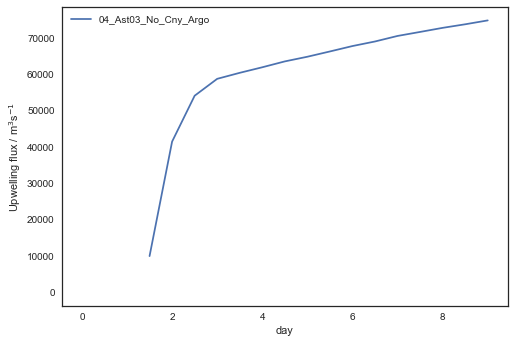

In [9]:
phi = np.sum(np.sum(wat_CS,axis=1),axis=1)+np.sum(np.sum(wat_LID,axis=1),axis=1)

plt.plot(time,phi, label=run)
plt.legend()
plt.xlabel('day')
plt.ylabel('Upwelling flux / m$^3$s$^{-1}$')
print('Mean upwelling flux days 4-9 is %1.2e m^3s^{-1} \pm %1.2e' %(np.mean(phi[8:]),np.std(phi[8:])))